<a href="https://colab.research.google.com/github/cincysam6/Field_Control_Model/blob/main/example_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# --- CONFIG: point these at your repo ---
REPO_URL = "https://github.com/cincysam6/Field_Control_Model.git"
REPO_DIR = "/content/Field_Control_Model"      # where to clone
PKG_ROOT = REPO_DIR                             # path to add to sys.path
REMOTE = "origin"
BRANCH = "main"                                 # or 'master' if you use that

# If your repo is private, set a token (or leave as None for public)
GITHUB_TOKEN = None  # e.g., "ghp_xxx..." or None for public

# ------------- helper: clone or pull -------------
import os, sys, subprocess, textwrap

def _run(cmd, cwd=None, check=True):
    print(" ".join(cmd))
    return subprocess.run(cmd, cwd=cwd, check=check, text=True, capture_output=True)

def ensure_repo(repo_url: str, repo_dir: str, remote="origin", branch="main", token=None, hard_reset=False):
    # Support private repos via token
    if token and repo_url.startswith("https://"):
        repo_url = repo_url.replace("https://", f"https://{token}@")

    if not os.path.exists(repo_dir):
        print(f"Cloning into {repo_dir} ...")
        _run(["git", "clone", "--recursive", repo_url, repo_dir])
    else:
        print(f"Repo exists at {repo_dir}. Fetching updates ...")
        _run(["git", "fetch", remote], cwd=repo_dir)
        if hard_reset:
            print(f"Hard resetting to {remote}/{branch} ...")
            _run(["git", "reset", "--hard", f"{remote}/{branch}"], cwd=repo_dir)
        else:
            print("Pulling latest changes ...")
            # Fast-forward only; avoids merge prompts in Colab
            try:
                _run(["git", "pull", "--ff-only", remote, branch], cwd=repo_dir)
            except subprocess.CalledProcessError as e:
                print("Fast-forward failed (local changes?). Falling back to hard reset.")
                _run(["git", "reset", "--hard", f"{remote}/{branch}"], cwd=repo_dir)

    # Ensure on the right branch
    _run(["git", "checkout", branch], cwd=repo_dir)

# ------------- do the fetch/pull -------------
ensure_repo(REPO_URL, REPO_DIR, remote=REMOTE, branch=BRANCH, token=GITHUB_TOKEN, hard_reset=False)

# ------------- put repo on sys.path -------------
if PKG_ROOT not in sys.path:
    sys.path.append(PKG_ROOT)

# ------------- turn on autoreload -------------
%load_ext autoreload
%autoreload 2

print("✅ Repo ready, path set, autoreload ON.")


Repo exists at /content/Field_Control_Model. Fetching updates ...
git fetch origin
Pulling latest changes ...
git pull --ff-only origin main
git checkout main
✅ Repo ready, path set, autoreload ON.


In [8]:
# 1. Clone your repo
#!git clone https://github.com/cincysam6/Field_Control_Model.git

# 2. Add it to Python path
#import sys
#sys.path.append('/content/Field_Control_Model')

# 3. Import your helper function
from src.helpers import compute_distances_by_frame
from src.diagnostic_plots import plot_dir_orientation_small_multiples

In [9]:
import pandas as pd

In [10]:
df = pd.read_csv('/content/drive/MyDrive/BDB_Data/pres_example_play.csv')
df.head()

,Unnamed: 0,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,team,...,is_off,position,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId,y_norm,x_norm,std_x,std_y,player_tags
0,1,2022092504,2617,38632.0,Kirk Cousins,1,BEFORE_SNAP,2022-09-25 19:03:06.2,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.87,1.84,off
1,2,2022092504,2617,38632.0,Kirk Cousins,2,BEFORE_SNAP,2022-09-25 19:03:06.3,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.86,1.83,off
2,3,2022092504,2617,38632.0,Kirk Cousins,3,BEFORE_SNAP,2022-09-25 19:03:06.4,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.86,1.83,off
3,4,2022092504,2617,38632.0,Kirk Cousins,4,BEFORE_SNAP,2022-09-25 19:03:06.5,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.85,1.82,off
4,5,2022092504,2617,38632.0,Kirk Cousins,5,BEFORE_SNAP,2022-09-25 19:03:06.6,8.0,MIN,...,1.0,QB,NaN,NaN,NaN,29.503333,74,-5.83,1.81,off


In [11]:
# Apply the function for each frameId group
df = df.groupby('frameId').apply(compute_distances_by_frame)

# Reset the index if needed
df.reset_index(drop=True, inplace=True)

# Verify results
print(df[['frameId', 'displayName', 'dist_from_football']])

      frameId         displayName  dist_from_football
0           1        Kirk Cousins            6.201815
1           1        Adam Thielen            6.730499
2           1      Charles Harris            2.227667
3           1       Alex Anzalone            3.314362
4           1        Johnny Mundt            5.450616
...       ...                 ...                 ...
4135      180  Christian Darrisaw           20.413538
4136      180        Alim McNeill           24.373954
4137      180           Ed Ingram           22.974850
4138      180   Malcolm Rodriguez            8.990200
4139      180            football            0.000000

[4140 rows x 3 columns]


/tmp/ipython-input-2934120900.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('frameId').apply(compute_distances_by_frame)


In [14]:
### Selecting a single player ID to test this out
one_player = [40488.0]
single_player = df[df['nflId'].isin(one_player)]

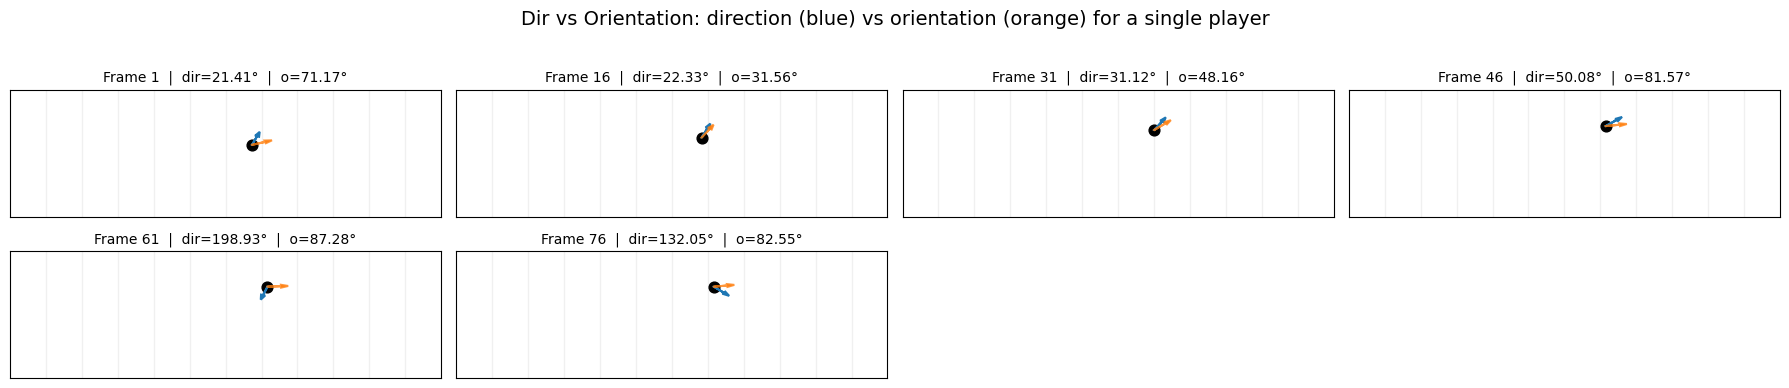

In [16]:
# df_player: rows for a single nflId on a single play
fig, axes = plot_dir_orientation_small_multiples(
    single_player,
    base_frame=int(single_player["frameId"].min()),
    offsets=(0, 15, 30, 45, 60, 75),
    arrow_len=5.0,
    scale_with_speed=True,
    show=True,
)